# 🔊 Working with Audio in Python

<img src="https://miro.medium.com/max/1100/1*Zx9QAMPzxhama9O4q9xWXg.jpeg" width="600"/>

This notebook is intended to be an introduction for anyone interested in using python to interperate audio data.

Please watch the youtube video that discusses the contents of this notebook if you want to learn more!
- [Video Link](https://www.youtube.com/watch?v=ZqpSb5p1xQo)
- [Youtube Channel](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw)

# Imports

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Terms to know for Audio in Digital Form:

## Frequency (Hz)
- Frequency describes the differences of wave lengths.
- We interperate frequency has high and low pitches.

<img src="https://uploads-cdn.omnicalculator.com/images/britannica-wave-frequency.jpg" width="400"/>

## Intensity (db / power)
- Intensity describes the amplitude (height) of the wave.

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124722804500162-f13-15-9780124722804.gif" width="400"/>

## Sample Rate
- Sample rate is specific to how the computer reads in the audio file.
- Think of it as the "resolution" of the audio.

<img src="https://www.headphonesty.com/wp-content/uploads/2019/07/Sample-Rate-Bit-Depth-and-Bit-Rate.jpeg" width="400"/>


# Reading in Audio Files
There are many types of audio files: `mp3`, `wav`, `m4a`, `flac`, `ogg`

In [81]:
audio_files = glob('UrbanSound8K/audio/fold1/*.wav')

In [82]:
# Play audio file
ipd.Audio(audio_files[0])

In [83]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.00011485 -0.00017083 -0.00017736 -0.00016102 -0.00013866 -0.00017711
 -0.00015624 -0.00027277 -0.00022342 -0.00023939]
shape y: (88200,)
sr: 22050


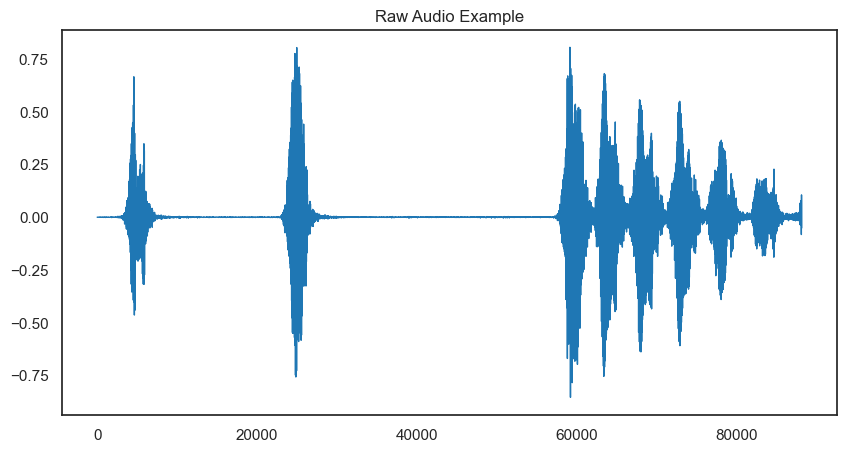

In [84]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

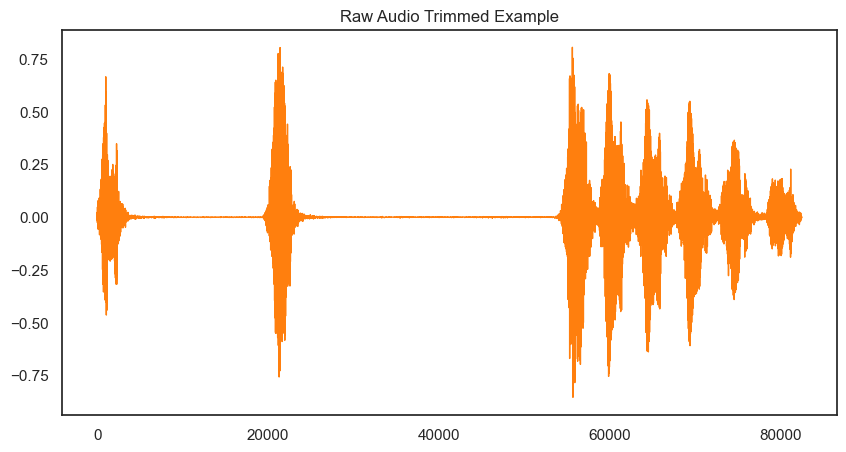

In [85]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

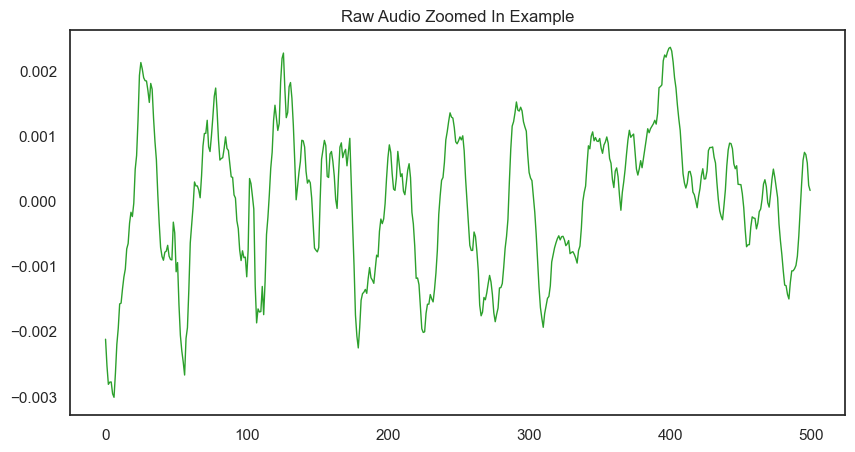

In [86]:
pd.Series(y[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

# Spectogram

In [87]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 173)

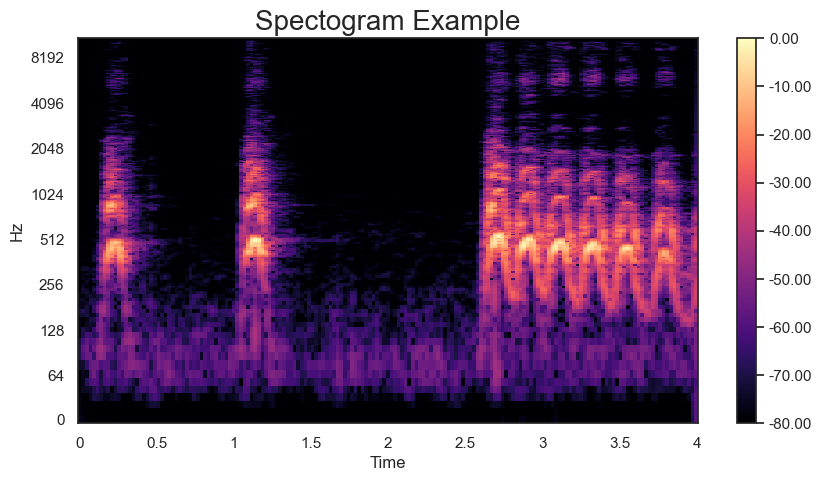

In [88]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Mel Spectogram

In [89]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=512,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

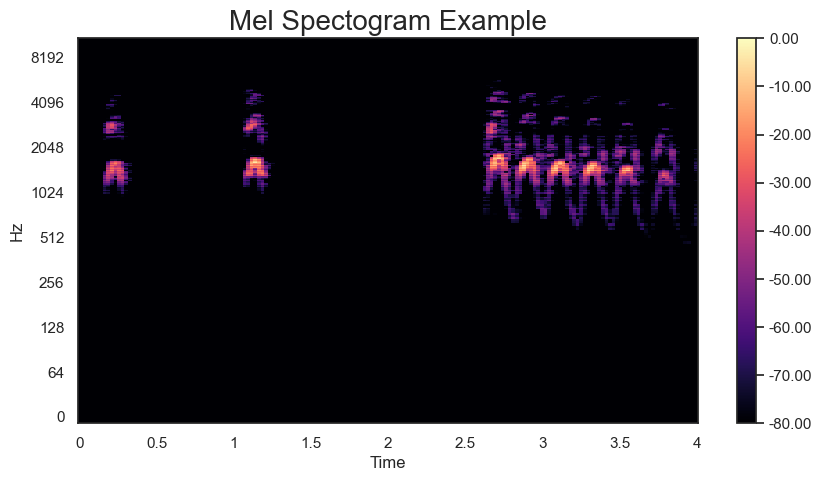

In [90]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
import glob
import os
import librosa
import numpy as np
import pandas as pd
from librosa.feature import melspectrogram

def LOG_MEL_SPEC(parent_dir, sub_dirs):
    labels = []
    log_mel_spectrogram = []
    exten = "*.wav"
    for l, sub_dir in enumerate(sub_dirs):
        for filename in glob.glob(os.path.join(parent_dir, sub_dir, exten)):
            # Extract label from filename - assuming the class name is embedded in the filename
            # You can adjust this depending on how the filenames are structured
            label = filename.split('fold')[1].split('-')[1]  # Adjust this as necessary for the filename format
            labels.append(int(label))  # Convert label to integer
            f, sr = librosa.load(filename, sr=44100)  # Load audio file with 44.1kHz sample rate
            
            # Define target duration (4 seconds)
            four_sec_samples = 4 * sr
            if len(f) >= four_sec_samples:
                # Take first 4 seconds if the audio is long enough
                log_mel_spec = librosa.power_to_db(melspectrogram(y=f[:four_sec_samples], sr=sr, n_fft=1024, hop_length=1024))
            else:
                # Pad audio to 4 seconds if it's shorter
                while len(f) < four_sec_samples:
                    f = np.concatenate((f, f))  # Zero padding by repeating (could change to zero-padding)
                log_mel_spec = librosa.power_to_db(melspectrogram(y=f[:four_sec_samples], sr=sr, n_fft=1024, hop_length=1024))
            
            log_mel_spectrogram.append(log_mel_spec)
    
    return np.array(log_mel_spectrogram), np.array(labels, dtype=int)

def encode(labels):
    # One hot encoding of labels
    labels_total = len(labels)
    unique_labels_total = len(np.unique(labels))
    one_hot_encoded = np.zeros((labels_total, unique_labels_total))
    one_hot_encoded[np.arange(labels_total), labels] = 1
    return one_hot_encoded

def file_Creater(final_path, filename):
    new_path = os.path.join(os.getcwd(), final_path)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    return os.path.join(final_path, filename)

# Set the parent directory where UrbanSound8K data is stored
parent_directory = 'UrbanSound8K/audio'  # Adjust this path as needed
final_dir = "UrbanSound8K/UrbanSound8K_Processed"
feature_file = file_Creater(final_dir, 'allfolds_features_x.npy')
labels_file = file_Creater(final_dir, 'allfolds_labels_y.npy')

# Process each fold and save the features and labels
sub_dirs = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']
features, labels = LOG_MEL_SPEC(parent_directory, sub_dirs)

# One hot encode the labels
labels_encoded = encode(labels)

# Save the extracted features and labels
np.save(feature_file, features)
print("DONE... " + feature_file)
np.save(labels_file, labels_encoded)
print("DONE... " + labels_file)


In [102]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Load the features and labels
features_file = 'UrbanSound8K/UrbanSound8K_Processed/allfolds_features_x.npy'
labels_file = 'UrbanSound8K/UrbanSound8K_Processed/allfolds_labels_y.npy'

features = np.load(features_file)
labels = np.load(labels_file)

# Reshape features for CNN input: (samples, height, width, channels)
features = features[..., np.newaxis]  # Add an extra dimension for channels (grayscale)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Build the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(features.shape[1], features.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels.shape[1], activation='softmax'))  # Softmax output for multi-class classification

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict on test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy Score: {accuracy}')


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.6220 - loss: 7.0463 - val_accuracy: 0.9309 - val_loss: 0.2893
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9309 - loss: 0.2098 - val_accuracy: 0.9673 - val_loss: 0.1335
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9575 - loss: 0.1996 - val_accuracy: 0.9745 - val_loss: 0.1247
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9856 - loss: 0.0560 - val_accuracy: 0.9673 - val_loss: 0.1086
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9837 - loss: 0.0436 - val_accuracy: 0.9709 - val_loss: 0.0971
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.9906 - loss: 0.0494 - val_accuracy: 0.9600 - val_loss: 0.1428
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9920 - loss: 0.0382 - val_accuracy: 0.9673 - val_loss: 0.1417
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9860 - loss: 0.0625 - val_accuracy: 0.

In [91]:
import tensorflow as tf
import librosa
import pandas as pd
import numpy as np
import os

def preprocess_audio(file_path, target_sr=22050, n_mels=128, duration=4.0):
    # Load and preprocess audio
    y, sr = librosa.load(file_path, sr=target_sr)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    fixed_length = int(target_sr * duration)
    if len(y_trimmed) < fixed_length:
        y = np.pad(y_trimmed, (0, fixed_length - len(y_trimmed)), mode="constant")
    else:
        y = y_trimmed[:fixed_length]
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())  # Normalize
    return mel_spec_db.astype(np.float32)

def load_data(csv_path, audio_folder):
    df = pd.read_csv(csv_path)
    file_paths = [os.path.join(audio_folder, f"fold{row['fold']}", row['slice_file_name']) for _, row in df.iterrows()]
    labels = df['classID'].values
    return file_paths, labels

def data_generator(file_paths, labels, target_sr=22050, n_mels=128, duration=4.0):
    for file_path, label in zip(file_paths, labels):
        mel_spec = preprocess_audio(file_path, target_sr, n_mels, duration)
        mel_spec = mel_spec[..., np.newaxis]  # Add channel dimension
        yield mel_spec, label

def create_dataset(csv_path, audio_folder, batch_size=32, target_sr=22050, n_mels=128, duration=4.0):
    file_paths, labels = load_data(csv_path, audio_folder)
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(file_paths, labels, target_sr, n_mels, duration),
        output_signature=(
            tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),  # Adjust based on mel-spectrogram size
            tf.TensorSpec(shape=(), dtype=tf.int64),
        )
    )
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [92]:
from tensorflow.keras import layers, models

def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),  # Dynamically flattens the output
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Final output layer
    ])
    return model


In [93]:
# Hyperparameters
BATCH_SIZE = 32
NUM_CLASSES = 10
INPUT_SHAPE = (128, None, 1)  # Adjust shape dynamically
EPOCHS = 20

# Load dataset
dataset = create_dataset(csv_path='UrbanSound8K/metadata/UrbanSound8K.csv', audio_folder='UrbanSound8K/audio', batch_size=BATCH_SIZE)

# Train-validation split
val_split = 0.2
dataset_size = len(list(dataset))
train_size = int((1 - val_split) * dataset_size)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Create model
model = create_cnn(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Save model
model.save("audio_classifier.h5")



C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Shapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 128) for variable path='sequential_1/dense_2/kernel'